In [131]:
### READING THE DATASET

import pandas as pd
import os as os
import numpy as np
# Creating empty list for broken tooth and healthy gearbox datasets
broken = []
healthy = []

# Defining the path where the datasets are stored
pth1 = 'dataset/BrokenTooth'
pth2 = 'dataset/Healthy'

# Reading the dataset as the list items using the OS library to access the files and read_csv function from pandas to read the daatasets 
# **Reading each file in the BrokenTooth and Healthy directories and appending it to the respective lists as pandas' DataFrame object (abbr.: df)
for file_name in sorted(os.listdir(pth1)):
    this_df = pd.read_csv(os.path.join(pth1, file_name))
    this_df['load'] = 10*int(file_name[5])
    this_df['gearbox_status'] = 0
    broken.append(this_df)

for file_name in sorted(os.listdir(pth2)):
    this_df = pd.read_csv(os.path.join(pth2, file_name))
    this_df['load'] = 10*int(file_name[5])
    this_df['gearbox_status'] = 1
    healthy.append(this_df)

print(broken[3])
print(healthy[3])

             a1        a2       a3         a4  load  gearbox_status
0     -0.016139  3.276840 -2.95850 -10.408800    30               0
1      4.907230 -2.153510 -3.41721  -5.889360    30               0
2     -2.024620 -1.548830  2.74703   1.037440    30               0
3      2.732660  3.733200  2.48229   4.093400    30               0
4      7.280710  3.443870  1.92867  -0.971704    30               0
...         ...       ...      ...        ...   ...             ...
89851  6.404300 -3.378610  2.22752  -0.397981    30               0
89852  4.374380 -2.926590 -1.63158  -2.984510    30               0
89853  1.542940 -0.811829 -6.32519  -4.545420    30               0
89854  0.742917  0.324594 -6.36588  -3.916870    30               0
89855 -4.917110  0.999914 -4.75481   1.223030    30               0

[89856 rows x 6 columns]
             a1         a2        a3        a4  load  gearbox_status
0       9.97455   3.270940  0.433691 -1.782170    30               1
1      -1.34088  -3.

In [132]:
# Aggregating dataset based on health status
# broken_agg = broken[0]
# healthy_agg = healthy[0]
# for i in range(1,10):
#     broken_agg = pd.concat([broken_agg, broken[i]], ignore_index=True)
#     healthy_agg = pd.concat([healthy_agg, healthy[i]], ignore_index=True)

In [133]:
import math

def divide_into(df, group_size):
    df_groups = []
    for i in range(math.ceil(df['a1'].count()/group_size)):
        new_df = df.iloc[i*group_size:(i+1)*group_size, :]
        df_groups.append(new_df)
    return df_groups

def get_group_stdevs(df, group_size):
    groups = divide_into(df, group_size)
    stdevs = pd.DataFrame(map(pd.DataFrame.std, groups))
    stdevs['load'] = df['load']
    stdevs['gearbox_status'] = df['gearbox_status']
    
    return stdevs

broken_stdev = []
for i in range(0,10):
    broken_stdev.append(get_group_stdevs(broken[i], group_size = 100))

healthy_stdev = []
for i in range(0,10):
    healthy_stdev.append(get_group_stdevs(healthy[i], group_size = 100))

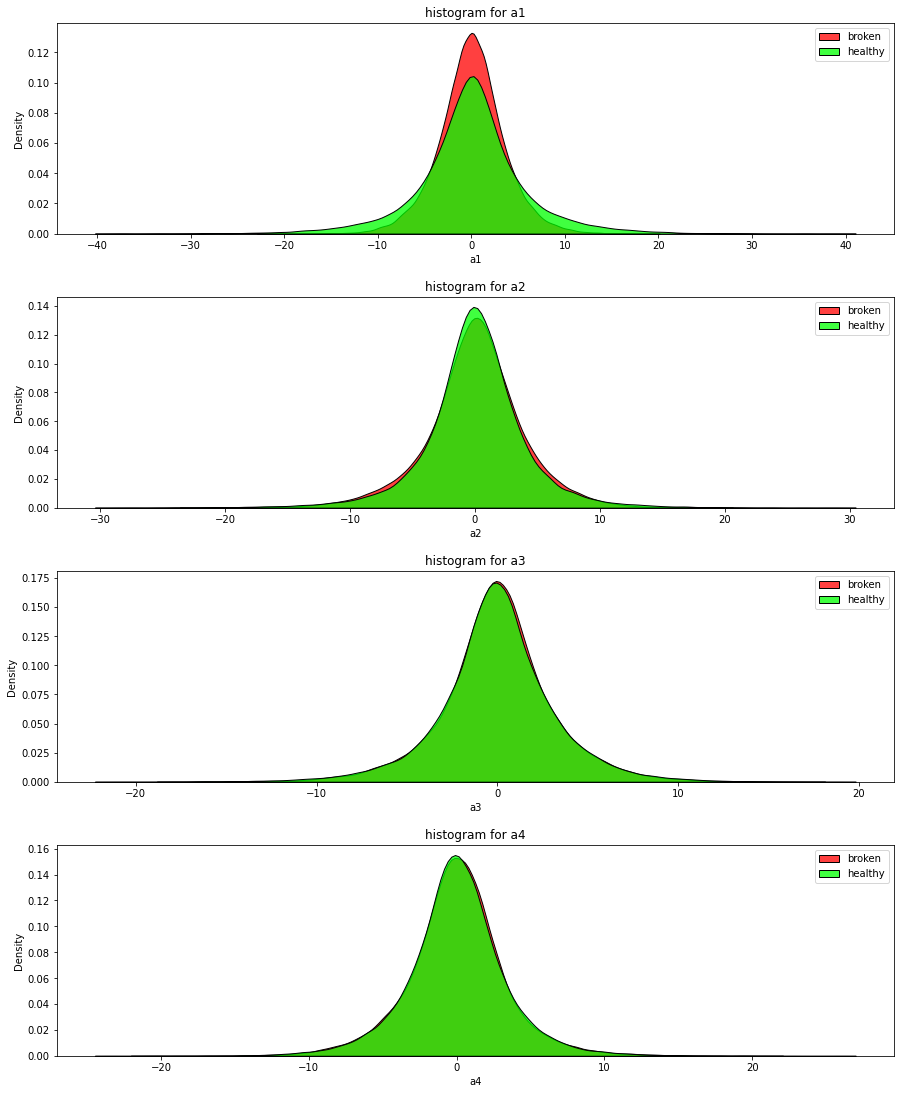

In [134]:
### DATA VISUALISATION

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

load = 0

plt.figure(figsize=(15,28*5))
plt.subplots_adjust(hspace = 0.3)
gs = gridspec.GridSpec(28, 1)
for i, col in enumerate(['a1','a2','a3','a4']):
    ax = plt.subplot(gs[i])
    sns.kdeplot(data = broken[load][col], color = "red", multiple="stack")
    sns.kdeplot(data = healthy[load][col], color = "lime", multiple="stack")
    # sns.timeplot
    plt.legend(['broken', 'healthy'])
    ax.set_title('histogram for ' + str(col))
plt.show()

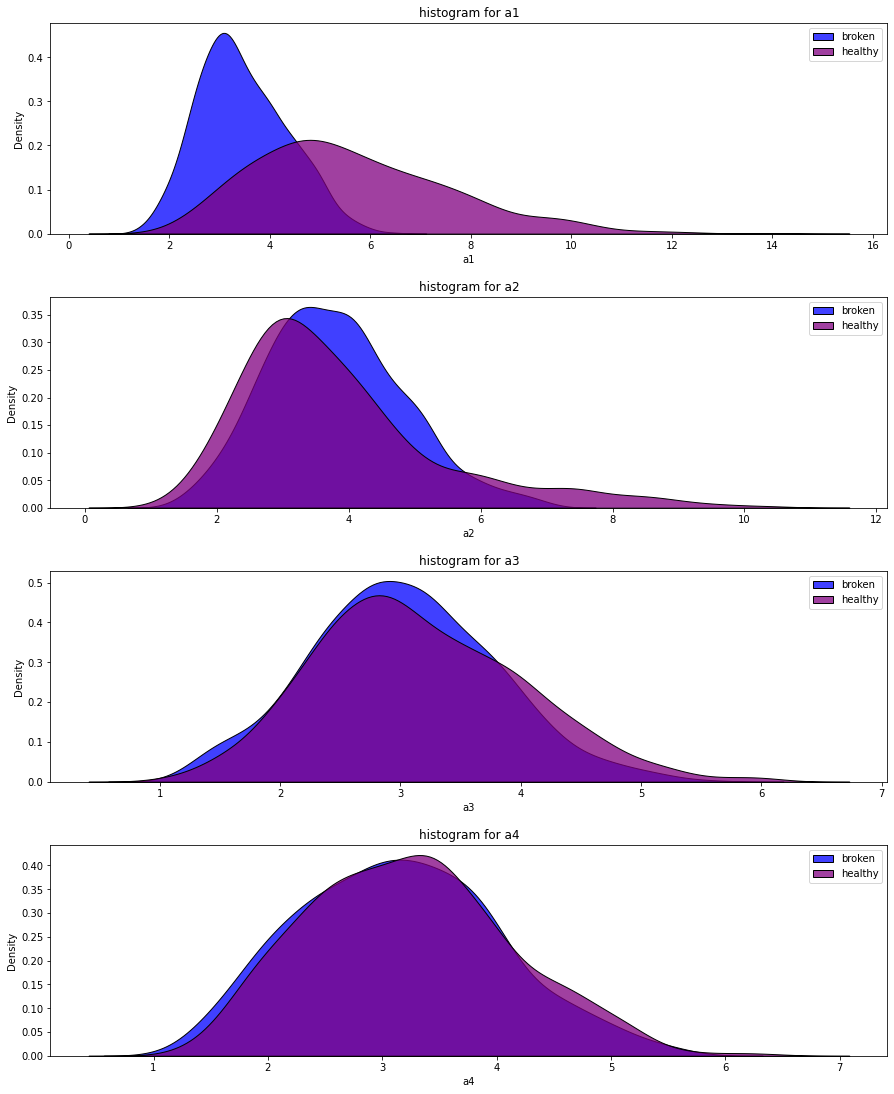

In [135]:
load = 0

plt.figure(figsize=(15,28*5))
plt.subplots_adjust(hspace = 0.3)
gs = gridspec.GridSpec(28, 1)
for i, val in enumerate(['a1','a2','a3','a4']):
    ax = plt.subplot(gs[i])
    sns.kdeplot(data = broken_stdev[load][val], color = "blue", multiple="stack")
    sns.kdeplot(data = healthy_stdev[load][val], color = "purple", multiple="stack")
    plt.legend(['broken', 'healthy'])
    ax.set_title('histogram for ' + str(val))
plt.show()

In [136]:
### DIVIDING THE DATASET FOR TRAINING, TESTING AND EVALUATION

import math

def segregate(df, load, fracs):
    total_size = len(df[load])
    train_frac = fracs[0]
    test_frac = fracs[1]
    eval_frac = fracs[2]

    training_set = df[load][['a1', 'load', 'gearbox_status']].iloc[:math.ceil(total_size * train_frac), :]
    testing_set = df[load][['a1', 'load', 'gearbox_status']].iloc[math.ceil(total_size * train_frac):math.ceil(total_size * (train_frac + test_frac)), :]
    eval_set = df[load][['a1', 'load', 'gearbox_status']].iloc[math.ceil(total_size * (train_frac + test_frac)):, :]
    
    return {
        'training': training_set,
        'testing': testing_set,
        'eval': eval_set
    }

H = segregate(healthy, load = 0, fracs = [0.6, 0.2, 0.2])
B = segregate(broken, load = 0, fracs = [0.6, 0.2, 0.2])

h = H['training']['a1']
b = B['training']['a1']

# sns.kdeplot(data = b, color="red", multiple="stack")
# sns.kdeplot(data = h, color="lime", multiple="stack")

18


<AxesSubplot:xlabel='a1', ylabel='Density'>

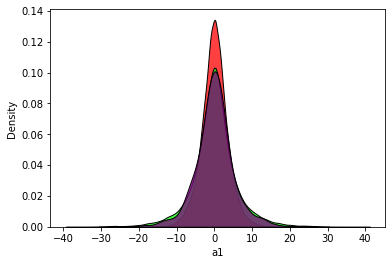

In [137]:
def n(stdev, mean):
    return (1/(stdev * math.sqrt(2*math.pi)))*(math.e)**(-0.5*((-mean/stdev)**2))

def ishealthy(x, tolerance):
    h = segregate(healthy, load = 0, fracs = [0.6, 0.2, 0.2])['training']['a1']
    return n(h.std(), h.mean())*(1 - tolerance) < n(x.std(), x.mean()) and n(x.std(), x.mean()) < n(h.std(), h.mean())*(1 + tolerance)

x = divide_into(H['testing'], 1000)
y = divide_into(H['eval'], 1000)

load = 0
# print(pd.DataFrame(map(lambda el: ishealthy(el['a1'], 0.5), x)))
# print(ishealthy(x[load]['a1'], tolerance = 0.086))
# print(ishealthy(y[load]['a1'], tolerance = 0.086))
# print(ishealthy(y[load]['a1'], tolerance = 0.08))

sns.kdeplot(b, color = "red", multiple="stack")
sns.kdeplot(h, color = "lime", multiple="stack")

print(len(x))
sns.kdeplot(x[0]['a1'], color="purple", multiple="stack")

In [138]:
# nh = len(healthy)
# nb = len(broken)

# nmin = min(nh, nb)

# def s(load):
#     _h = healthy[load].iloc[:nmin, :]
#     _b = broken[load].iloc[:nmin, :]
#     return _h.subtract(_b)['a1']

# # sns.kdeplot(s['a1'], color = "red", multiple="stack")
# # print(s(0).describe())

# __s = []
# for i in range(10):
#     _s = s(i)
#     print(_s.mean(), _s.std())
#     __s.append(_s.std())

# sns.kdeplot(__s)

<AxesSubplot:>

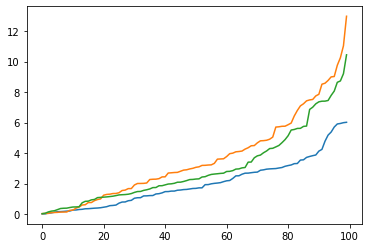

In [196]:
# print(broken[0].abs().sort_values(by=['a1']))
# print(healthy[0].abs().sort_values(by=['a1']))
i = 5000
step = 100
a = broken[0]['a1'].iloc[i : i+step].abs().sort_values(ascending=True)
b = healthy[0]['a1'].iloc[i : i+step].abs().sort_values(ascending=True)

c = b.subtract(a).abs().sort_values(ascending=True)

# print(list(a))
# print(b)
sns.lineplot(data=list(a))
sns.lineplot(data=list(b))
sns.lineplot(data=list(c))